Training, testing, and optimizing the 3 CNNs (gender, ethnicity, and age prediction)

# Imports

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15820901173970706118
]


In [5]:
tf.config.list_physical_devices('GPU')

[]

# Data Handling

In [6]:
data = pd.read_csv('D:/ML_Data/age_gender_ethnicity/age_gender.csv')
data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype="float32")) # Convert the spaced integers into a list of floats

In [7]:
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [8]:
data.shape

(23705, 5)

In [9]:
data['pixels'] = data['pixels'].apply(lambda x: x/255)

In [10]:
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([go.Bar(x=x, y=y)])

    fig.update_layout(title_text=name)
    fig.show()

In [11]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

In [12]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

In [13]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

In [14]:
X = np.array(data['pixels'].tolist())
X = X.reshape(X.shape[0],48,48,1)

In [15]:
def show_sample_img(index):
    plt.imshow(data['pixels'].iloc[index].reshape(48,48))
    plt.xlabel(
            "Age:"+str(data['age'].iloc[index])+
            "  Ethnicity:"+str(data['ethnicity'].iloc[index])+
            "  Gender:"+ str(data['gender'].iloc[index])
        )

In [16]:
data.loc[(data['ethnicity'] == 4) & (data['age'] >= 29) & (data['age'] <= 31)]

,age,ethnicity,gender,img_name,pixels
9963,29,4,1,20170117202752934.jpg.chip.jpg,"[0.003921569, 0.015686275, 0.007843138, 0.0156..."
9966,29,4,1,20170117202750455.jpg.chip.jpg,"[0.25882354, 0.26666668, 0.2627451, 0.23921569..."
9967,29,4,1,20170117202704359.jpg.chip.jpg,"[0.18039216, 0.14117648, 0.15294118, 0.2117647..."
9968,29,4,1,20170117123747223.jpg.chip.jpg,"[0.58431375, 0.58431375, 0.5803922, 0.56078434..."
9969,29,4,1,20170113011257168.jpg.chip.jpg,"[0.0627451, 0.07058824, 0.09411765, 0.16862746..."
...,...,...,...,...,...
11823,31,4,0,20170116214318093.jpg.chip.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156..."
11825,31,4,0,20170117020719427.jpg.chip.jpg,"[0.09803922, 0.105882354, 0.105882354, 0.10588..."
11826,31,4,0,20170117153920514.jpg.chip.jpg,"[0.13333334, 0.12941177, 0.12156863, 0.1058823..."
11827,31,4,0,20170120133240958.jpg.chip.jpg,"[0.1254902, 0.101960786, 0.13333334, 0.2235294..."


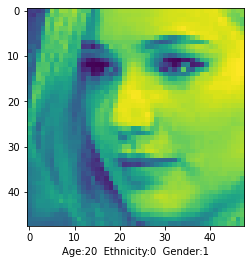

In [17]:
show_sample_img(3204) # 20, Caucasian, Female

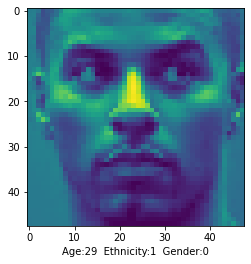

In [18]:
show_sample_img(9989) # 29, African, Male

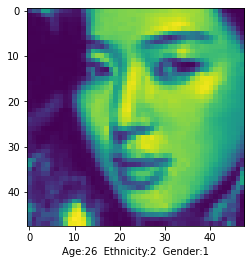

In [19]:
show_sample_img(6215) # 26, East Asian, Female

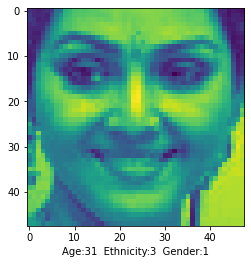

In [20]:
show_sample_img(11768) # 31, South Asian, Female

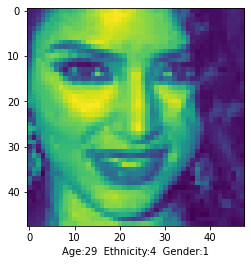

In [21]:
show_sample_img(9969) # 29, Latino, Female

# Gender Prediction (1)

In [22]:
y1 = data['gender']

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y1, test_size=0.22, random_state=37
)

In [23]:
model1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(48,48,1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
]) # CNN number 1

In [24]:
model1.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Stop training when validation loss reaches 0.2700
class callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2700):
            print("\nReached 0.2700 val_loss so training voided")
            self.model.stop_training = True

callback = callback()

In [25]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [50]:
history = model1.fit(
    X_train1, y_train1, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
260/260 [==============================] - 32s 122ms/step - loss: 0.5103 - accuracy: 0.7451 - val_loss: 0.5941 - val_accuracy: 0.8167
Epoch 2/20
260/260 [==============================] - 30s 114ms/step - loss: 0.3908 - accuracy: 0.8263 - val_loss: 0.4122 - val_accuracy: 0.8350
Epoch 3/20
260/260 [==============================] - 29s 113ms/step - loss: 0.3532 - accuracy: 0.8412 - val_loss: 0.3399 - val_accuracy: 0.8556
Epoch 4/20
260/260 [==============================] - 29s 112ms/step - loss: 0.3294 - accuracy: 0.8532 - val_loss: 0.3409 - val_accuracy: 0.8448
Epoch 5/20
260/260 [==============================] - 29s 112ms/step - loss: 0.3145 - accuracy: 0.8604 - val_loss: 0.3109 - val_accuracy: 0.8643
Epoch 6/20
260/260 [==============================] - 29s 112ms/step - loss: 0.2996 - accuracy: 0.8685 - val_loss: 0.3092 - val_accuracy: 0.8594
Epoch 7/20
260/260 [==============================] - 29s 113ms/step - loss: 0.2860 - accuracy: 0.8754 - val_loss: 0.3078 - val_ac

In [52]:
model1.save('gender_model.h5')

In [26]:
model1 = tf.keras.models.load_model('models\gender_model.h5')
model1

In [34]:
def local_predict_gender(index):
    '''Predict gender from an image in the local dataset'''
    input_img = X_test1[index]
    plt.imshow(input_img)
    pred = model1.predict(np.expand_dims(input_img, axis=0))[0]

    gender = 'Female'
    if pred < 0.5:
        gender = 'Male'
        
    print(f'Prediction: {pred} -> {gender}')

Prediction: [0.99789363] -> Female


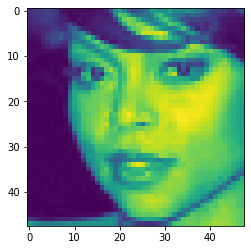

In [35]:
local_predict_gender(2)

Prediction: [0.01874089] -> Male


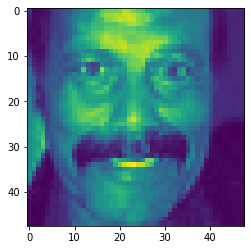

In [36]:
local_predict_gender(38)

Prediction: [0.00999564] -> Male


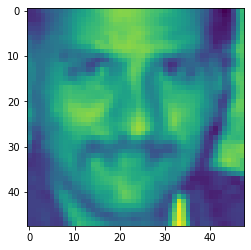

In [39]:
local_predict_gender(396)

# Ethnicity Prediction (2)

In [54]:
y2 = data['ethnicity']

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y2, test_size=0.22, random_state=37
)

model2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(48,48,1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=5)
])

In [55]:
model2.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])    
              
class callback2(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.790):
            print("\nReached 79% val_accuracy so training voided")
            self.model.stop_training = True

callback2 = callback2()

In [56]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [57]:
history = model2.fit(
    X_train2, y_train2, epochs=16, validation_split=0.1, batch_size=64, callbacks=[callback2]
)

Epoch 1/16
260/260 [==============================] - 15s 59ms/step - loss: 1.2409 - accuracy: 0.5271 - val_loss: 0.9278 - val_accuracy: 0.6549
Epoch 2/16
260/260 [==============================] - 15s 57ms/step - loss: 0.9629 - accuracy: 0.6605 - val_loss: 0.8109 - val_accuracy: 0.7236
Epoch 3/16
260/260 [==============================] - 15s 57ms/step - loss: 0.8693 - accuracy: 0.7002 - val_loss: 0.7797 - val_accuracy: 0.7236
Epoch 4/16
260/260 [==============================] - 15s 58ms/step - loss: 0.7999 - accuracy: 0.7218 - val_loss: 0.7074 - val_accuracy: 0.7637
Epoch 5/16
260/260 [==============================] - 15s 57ms/step - loss: 0.7550 - accuracy: 0.7405 - val_loss: 0.6648 - val_accuracy: 0.7680
Epoch 6/16
260/260 [==============================] - 15s 57ms/step - loss: 0.7195 - accuracy: 0.7514 - val_loss: 0.6391 - val_accuracy: 0.7777
Epoch 7/16
260/260 [==============================] - 15s 57ms/step - loss: 0.6772 - accuracy: 0.7694 - val_loss: 0.6245 - val_accuracy:

In [44]:
model2.save('ethnicity_model.h5')

In [89]:
def local_predict_ethnicity(index):
    '''Predict ethnicity from an image in the local dataset'''
    input_img = X_test1[index]
    plt.imshow(input_img)
    pred = model2.predict(np.expand_dims(input_img, axis=0))

    label_map = ['Caucasian', 'African', 'East Asian', 'South Asian', 'Latino']
    ethnicity = label_map[np.argmax(pred)]
        
    print(f'Prediction: {pred[0][np.argmax(pred)]} -> {ethnicity}')

Prediction: 4.8505778312683105 -> African


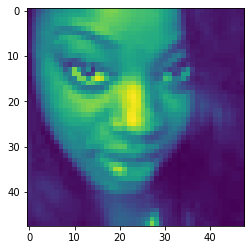

In [90]:
local_predict_ethnicity(0)

Prediction: 8.237634658813477 -> East Asian


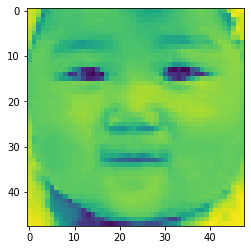

In [92]:
local_predict_ethnicity(54)

Prediction: 5.441193103790283 -> Caucasian


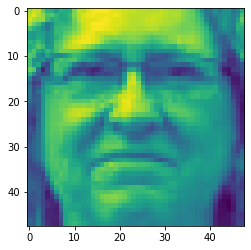

In [93]:
local_predict_ethnicity(210)

# Age Prediction (3)

In [95]:
y3 = data['age']

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X, y3, test_size=0.22, random_state=37
)

In [96]:
model3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(48,48,1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1, activation='relu')
])

sgd = tf.keras.optimizers.SGD(momentum=0.9)

In [101]:
model3.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

class callback3(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so training voided")
            self.model.stop_training = True
        
callback3 = callback3()

model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 128)        

In [104]:
history = model3.fit(
    X_train3, y_train3, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback3]
)

Epoch 1/20
260/260 [==============================] - 29s 113ms/step - loss: 100.4214 - mae: 7.3791 - val_loss: 127.7845 - val_mae: 8.1746
Epoch 2/20
260/260 [==============================] - 28s 110ms/step - loss: 97.0174 - mae: 7.2730 - val_loss: 132.9553 - val_mae: 8.8922
Epoch 3/20
260/260 [==============================] - 28s 109ms/step - loss: 93.5612 - mae: 7.1241 - val_loss: 116.0183 - val_mae: 8.1764
Epoch 4/20
260/260 [==============================] - 28s 109ms/step - loss: 90.2766 - mae: 7.0007 - val_loss: 116.5936 - val_mae: 8.2770
Epoch 5/20
260/260 [==============================] - 28s 109ms/step - loss: 90.3503 - mae: 6.9957 - val_loss: 114.1373 - val_mae: 8.0441
Epoch 6/20
260/260 [==============================] - 28s 109ms/step - loss: 86.2215 - mae: 6.8642 - val_loss: 115.6384 - val_mae: 7.7643
Epoch 7/20
260/260 [==============================] - ETA: 0s - loss: 87.7428 - mae: 6.8828
Reached 110 val_loss so training voided
260/260 [==============================

In [105]:
model3.save('age_model.h5')